# Single Container Model Development

In this notebook, our goal is to develop the necessary model for a single container
with varying concurrency levels.


In [1]:
%load_ext autoreload
%autoreload 2
# imports

# important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy as sp

from tqdm.auto import tqdm

# for better printing of variables
from IPython.display import display

In [2]:
# custom imports
from concperf import single_model, general_model
from concperf import utility

# Introduction

## Methods For Calculating Concurrency Distribution

### Method 1: Assuming Homogeneous Cluster

In this method, we assume a homogeneous cluster and thus the arrival rate for each server is $\lambda/N$ and solving for
the steady-state $\pi$ of a single container solves it for all of them. The main issue with this approach is that
it doesn't capture the synchronous behaviour of the servers as the load balancer wouldn't let one server to be overwhelmed
while we have idle servers. To address this, we might want to do the second method.

The main strong point of this method is that it captures the effect of concurrency on the service rate completely.
This is very important as for most workloads with $CC>1$ we would want to have different service rates on different
concurrency values. Because this seems to be very important for now, we will go ahead with this method until we decide
that the merits of the second method are woth more.

### Method 2: Single Chain For The Cluster

In this method, we use a single chain for the whole cluster. This way, we capture the synchronized behaviour of the cluster
with more fidelity, but we lose our ability to work on the change in service rate with different concurrency values.

# Calculating Concurrency Distribution using Method 1

In [3]:
# update configuration dictionary
def update_config(config):
    config['arrival_rate_server'] = config['arrival_rate_total'] / config['instance_count']
    config['base_service_time'] = config['base_service_time_ms'] / 1000


In [4]:
single_container_config = {
    'instance_count': 10,
    'max_conc': 10,
    'arrival_rate_total': 5,
    'alpha': 0.11,
    'base_service_time_ms': 1154,
    'max_container_count': 25,
    'target_conc': 0.7, # assumes target utilization
    'max_scale_up_rate': 1000, # from N to 1000*N at most
    'max_scale_down_rate': 2, # from N to N/2 at most
}

# update the config
update_config(single_container_config)
display(single_container_config)

single_coder = single_model.StateCoder(config=single_container_config)

# calculate and show Q
Q = single_model.get_single_container_q(single_coder, config=single_container_config)
display(pd.DataFrame(Q))

req_count_prob = utility.solve_CTMC(Q)
# display solution for debug purposes
# display([f"{s:4.2f}" for s in req_count_prob])

# calculate average and deviation
req_df = pd.DataFrame(data = {
    'req_count': [s[0] for s in single_coder.get_state_list()],
    'req_count_prob': req_count_prob,
})
display(req_df)

{'instance_count': 10,
 'max_conc': 10,
 'arrival_rate_total': 5,
 'alpha': 0.11,
 'base_service_time_ms': 1154,
 'max_container_count': 25,
 'target_conc': 0.7,
 'max_scale_up_rate': 1000,
 'max_scale_down_rate': 2,
 'arrival_rate_server': 0.5,
 'base_service_time': 1.154}

,0,1,2,3,4,5,6,7,8,9,10
0,-0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.866551,-1.366551,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,1.561353,-2.061353,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,2.130863,-2.630863,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,2.606169,-3.106169,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,3.008858,-3.508858,0.500000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,3.354391,-3.854391,0.500000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.654131,-4.154131,0.500000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.916615,-4.416615,0.500000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.148383,-4.648383,0.500000


,req_count,req_count_prob
0,0,5.509425e-01
1,1,3.178938e-01
2,2,1.018007e-01
3,3,2.388720e-02
4,4,4.582820e-03
5,5,7.615546e-04
6,6,1.135161e-04
7,7,1.553257e-05
8,8,1.982907e-06
9,9,2.389975e-07


Concurrency: 0.6161040935667044(avg) +- 0.8110844781803102(std)


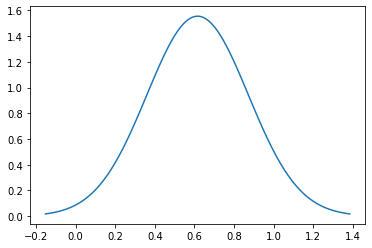

In [5]:
# calculate average concurrency
req_count_mean, req_count_std = utility.get_normal_dist_params(vals=req_df['req_count'], probs=req_df['req_count_prob'])
utility.plot_normal_fit(vals=req_df['req_count'], probs=req_df['req_count_prob'], avg_count=10)
# req_count_avg = (req_df['req_count'] * req_df['req_count_prob']).sum()
print(f"Concurrency: {req_count_mean}(avg) +- {req_count_std}(std)")

### Comparing Calculated Normal Fit With Other Calculations

<BarContainer object of 11 artists>

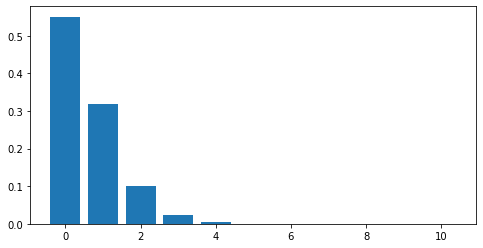

In [6]:
# plot initial values
plt.figure(figsize=(8,4))
plt.bar(req_df['req_count'], req_df['req_count_prob'])

Calculation took 0.4550914764404297 seconds


(-1.0, 3.0)

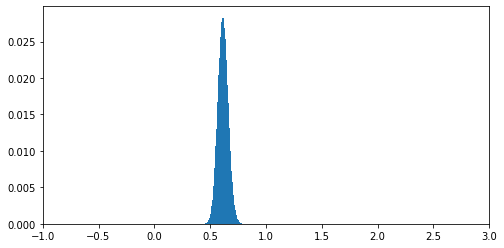

In [7]:
avg_count = 300

import time
start_time = time.time()
req_count_averaged_vals, req_count_averaged_probs = utility.get_averaged_distribution(vals=req_df['req_count'], probs=req_df['req_count_prob'], avg_count=avg_count)
print(f"Calculation took {time.time() - start_time} seconds")

plt.figure(figsize=(8,4))
plt.bar(req_count_averaged_vals, req_count_averaged_probs, width=1/avg_count)
plt.xlim([-1,3])

# Calculate Ordered Containers

,new_order_val,new_order_prob
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
5,5,0.000000
6,6,0.000000
7,7,0.002307
8,8,0.104842
9,9,0.527438


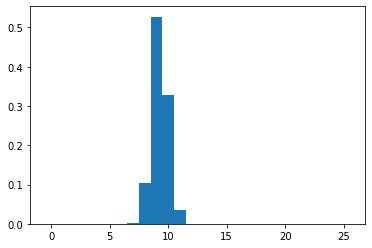

In [8]:
new_order_val, new_order_prob = general_model.get_new_order_dist(req_count_averaged_vals, req_count_averaged_probs, single_container_config)

# plot the result
plt.bar(new_order_val, new_order_prob, width=1)

# show results as pandas dataframe
display(pd.DataFrame(data = {
    'new_order_val': new_order_val,
    'new_order_prob': new_order_prob,
}))

## Checking Edge Case

Here, we check very low arrival rate case just to be sure everything is on track.

<BarContainer object of 26 artists>

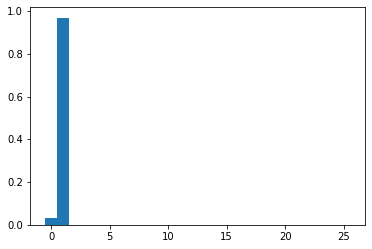

In [9]:
# checking edge case
single_container_config.update({
    'instance_count': 1,
    'arrival_rate_total': .01,
})

update_config(single_container_config)

# calculate and show Q
Q = single_model.get_single_container_q(single_coder, config=single_container_config)
req_count_prob = utility.solve_CTMC(Q)
# calculate average and deviation
req_df = pd.DataFrame(data = {
    'req_count': [s[0] for s in single_coder.get_state_list()],
    'req_count_prob': req_count_prob,
})
req_count_averaged_vals, req_count_averaged_probs = utility.get_averaged_distribution(vals=req_df['req_count'], probs=req_df['req_count_prob'], avg_count=avg_count)
new_order_val, new_order_prob = general_model.get_new_order_dist(req_count_averaged_vals, req_count_averaged_probs, single_container_config)

# plot the result
plt.bar(new_order_val, new_order_prob, width=1)

<BarContainer object of 26 artists>

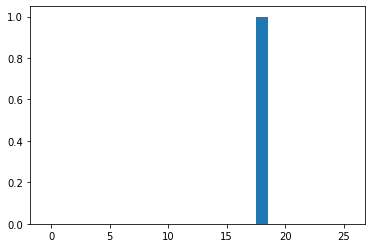

In [10]:
# checking another edge case
single_container_config.update({
    'instance_count': 2,
    'arrival_rate_total': 15,
    'alpha': 1,
    'base_service_time_ms': 200,
    'target_conc': 16*0.7, # assumes target utilization
    'max_conc': 100,
})

update_config(single_container_config)

# update state coder
single_coder = single_model.StateCoder(config=single_container_config)

# calculate and show Q
Q = single_model.get_single_container_q(single_coder, config=single_container_config)
req_count_prob = utility.solve_CTMC(Q)
# calculate average and deviation
req_df = pd.DataFrame(data = {
    'req_count': [s[0] for s in single_coder.get_state_list()],
    'req_count_prob': req_count_prob,
})
req_count_averaged_vals, req_count_averaged_probs = utility.get_averaged_distribution(vals=req_df['req_count'], probs=req_df['req_count_prob'], avg_count=avg_count)
new_order_val, new_order_prob = general_model.get_new_order_dist(req_count_averaged_vals, req_count_averaged_probs, single_container_config)

# plot the result
plt.bar(new_order_val, new_order_prob, width=1)

# Plot Average Concurrency vs. Arrival Rate Per Container

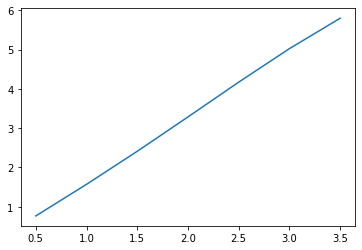

In [21]:
single_container_config = {
    'instance_count': 1,
    'max_conc': 10,
    'alpha': 0.03,
    'base_service_time_ms': 1500,
}

res = []
for arrival_rate in np.linspace(0.5, 3.5, 7):
    single_container_config.update({
        'arrival_rate_total': arrival_rate,
    })

    update_config(single_container_config)

    # calculate and show Q
    Q = single_model.get_single_container_q(single_coder, config=single_container_config)
    req_count_prob = utility.solve_CTMC(Q)
    # calculate average and deviation
    req_df = pd.DataFrame(data = {
        'req_count': [s[0] for s in single_coder.get_state_list()],
        'req_count_prob': req_count_prob,
    })

    mean_conc = (req_df['req_count'] * req_df['req_count_prob']).sum()

    res.append({
        'arrival_rate': arrival_rate,
        'mean_conc': mean_conc,
    })

tmpdf = pd.DataFrame(data=res)
tmpdf.head()

plt.plot(tmpdf['arrival_rate'], tmpdf['mean_conc'])